# Intro
Many algorithms compute the Eucilidean Distance between two observations and if one of the features is vastly larger than another, the distance will be biased towards that particular feature. To normalize the data, for each value, subtract each the mean and then divide by the standard deviation.

The associated dataset includes professional golf driving statistics that contain the golfer's driving distance and accuracy. Since the distance is measured in yards and the accuracy in percentage, it's important to normalize the data before using it to avoid biases in the learning algorithms. 

   distance  accuracy
0  0.314379 -0.707727
1  1.693777 -1.586669
2 -0.059695 -0.176699
3 -0.574047  0.372640
4  1.343083 -1.934584


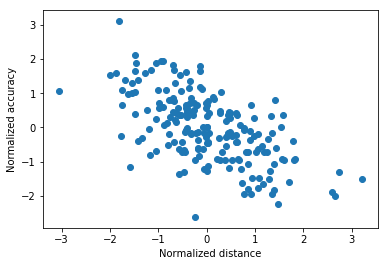

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook

pga = pd.read_csv('pga.csv')

# Normalize the data
pga.distance = (pga.distance - pga.distance.mean()) / pga.distance.std()
pga.accuracy = (pga.accuracy - pga.accuracy.mean()) / pga.accuracy.std()
print(pga.head())

plt.scatter(pga.distance, pga.accuracy)
plt.xlabel('Normalized distance')
plt.ylabel('Normalized accuracy')
plt.show()

As expected, the data shows a negative trending relationship between the two variables. Namely, as the driving distance increases the accuracy of the shot will decrease. This relationship can be fitted to a linear model using `sklearn`'s `LinearRegression` class to estimate the model.

In [2]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Add dimension to an array by using np.newaxis
print("Shape of the series:", pga.distance.shape)
print("Shape with newaxis:", pga.distance[:, np.newaxis].shape)

Shape of the series: (197,)
Shape with newaxis: (197, 1)


In [3]:
lm = LinearRegression()
lm.fit(pga.distance[:, np.newaxis], pga.accuracy)
theta1 = lm.coef_[0]
print(theta1)

-0.607598822715


The sklearn library estimates the coefficients of our linear model, using least squares. The least squares method can effectively fit linear models since it only requires matrix algebra and provides deterministic estimates of the coefficients. Least squares is a method which directly minimized the sum of square error in a model algebraically. Often times we have too much data to fit into memory and we can't use least squares.

Gradient descent is a general method that can be used to estimate coefficents of nearly any model, including linear models. At it's core, gradient descent minimizes the residuals in the estimated model by updating each coefficent based on it's gradient.

Cost functions measure the difference between a model predictions and it's corresponding observations with the coefficients as parameters. Lets say our model is $h_\theta(x) = \theta_1x + \theta_0$, the associated cost function would then be defined as $J(\theta_0,\theta_1)=\frac{1}{2m}\sum_{i=1}^{m}(h_\theta(x_i)-y_i)^2$, or half the average difference between the prediction and the observation squared.

1.5994384226


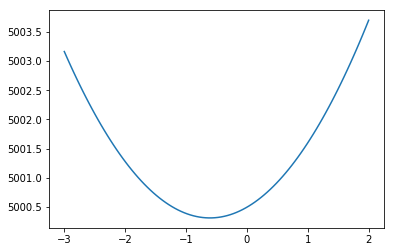

In [4]:
def cost(theta0, theta1, x, y):
    # Initialize the cost
    J = 0
    # Number of observations 
    m = len(x)
    for i in range(m):
        # Compute hypothesis
        h = theta1*x[i] + theta0
        # Add to cost
        J+= (h - y[i])**2
    # Average and normalize cost
    J /= (2*m)
    return J

print(cost(0,1,pga.distance, pga.accuracy))

theta0 = 100
theta1s = np.linspace(-3,2,100)
costs = []
for theta1 in theta1s:
    costs.append(cost(theta0, theta1, pga.distance, pga.accuracy))
plt.plot(theta1s,costs)

The minimum of the cost function is where the model as the lowest error and where the parameters are optimized, but this model only minimizes the slope while keeping the intercept constant. Therefore both $\theta_0$ and $\theta_1$ must be optimized and this can be visualized using a 3D plot.

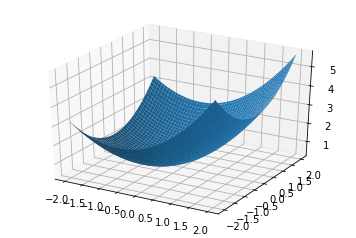

In [5]:
from mpl_toolkits.mplot3d import Axes3D

theta0s = np.linspace(-2,2,100)
theta1s = np.linspace(-2,2,100)
COST = np.empty(shape=(100,100))

T0S, T1S = np.meshgrid(theta0s, theta1s)
for i in range(100):
    for j in range(100):
        COST[i,j] = cost(T0S[0,i], T1S[j,0], pga.distance, pga.accuracy)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X=T0S, Y=T1S, Z=COST)
plt.show()

From this 3D plot, we can better understand how the gradient is affected in both the X and Y direction. By taking the partial derivative of the function with respect to both parameters $\theta_0$ and $\theta_1$, we can show the direction of the largest gradient.

In [6]:
def partial_cost_theta1(theta0, theta1, x, y):
    h = theta0 + theta1*x
    diff = (h-y)*x
    partial = diff.sum() / (x.shape[0])
    return partial

def partial_cost_theta0(theta0, theta1, x, y):
    h = theta0 + theta1*x
    diff = (h-y)
    partial = diff.sum() / (x.shape[0])
    return partial

partial1 = partial_cost_theta1(0, 5, pga.distance, pga.accuracy)
partial0 = partial_cost_theta0(1, 1, pga.distance, pga.accuracy)
print('partial1 =', partial1)
print('partial0 =', partial0)

partial1 = 5.5791338540718955
partial0 = 1.0000000000000104


To execute gradient descent we randomly initialize a set of parameters and update them by moving in the direction of the cost function's steepest slope, ie. the descending down the function. If we can find the downward slope in terms of each parameter we can move in the direction of the global minumum. Eventually the updates will converge to a near optimal set of parameters. 

Theta1 = -0.6046983166379609


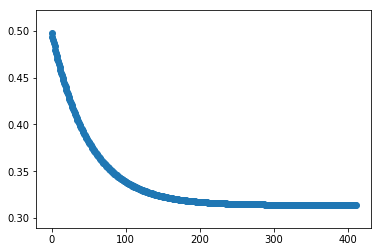

In [7]:
# x is our feature vector -- distance
# y is our target variable -- accuracy
# alpha is the learning rate
# theta0 is the intial theta0 
# theta1 is the intial theta1
def gradient_descent(x, y, alpha=0.1, theta0=0, theta1=0):
    max_epochs = 1000 # Maximum number of iterations
    counter = 0      # Intialize a counter
    c = cost(theta1, theta0, pga.distance, pga.accuracy)  # Initial cost
    costs = [c]     # Store each update
    # Set a convergence threshold to find where the cost function in minimized
    # When the difference between the previous cost and current cost 
    # is less than this value we will say the parameters converged
    convergence_thres = 0.000001  
    cprev = c + 10   
    theta0s = [theta0]
    theta1s = [theta1]

    # When the costs converge or we hit a large number of iterations will we stop updating
    while (np.abs(cprev - c) > convergence_thres) and (counter < max_epochs):
        cprev = c
        # Alpha times the partial deriviative is our updated
        update0 = alpha * partial_cost_theta0(theta0, theta1, x, y)
        update1 = alpha * partial_cost_theta1(theta0, theta1, x, y)

        # Update theta0 and theta1 at the same time
        # We want to compute the slopes at the same set of hypothesised parameters
        # so we update after finding the partial derivatives
        theta0 -= update0
        theta1 -= update1
        
        # Store thetas
        theta0s.append(theta0)
        theta1s.append(theta1)
        
        # Compute the new cost
        c = cost(theta0, theta1, pga.distance, pga.accuracy)

        # Store updates
        costs.append(c)
        counter += 1   # Count

    return {'theta0': theta0, 'theta1': theta1, "costs": costs}

print("Theta1 =", gradient_descent(pga.distance, pga.accuracy)['theta1'])
descend = gradient_descent(pga.distance, pga.accuracy, alpha=.01)
plt.scatter(range(len(descend['costs'])), descend['costs'])
plt.show()

The gradient descent method provides a nearly identical $\theta_1$ value to that produced from the least squares method produced earlier (-0.6076)